# Loading original dataset

In [34]:
import matplotlib.pyplot as plt
import xgboost as xgb
import numpy as np
from datetime import date
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from mpl_toolkits.mplot3d import axes3d
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, confusion_matrix, f1_score
import pandas as pd
from sklearn.model_selection import train_test_split
from datetime import date
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
# Will allow us to embed images in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 7.5)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

r = 666
np.random.seed(r)

dataset = pd.read_csv("../common/dataset.csv", header=0, index_col='CUST_COD')
# Backup original dataset
orig_dataset = dataset.copy()

print(dataset.shape)

(26884, 24)


In [3]:
orig_dataset.head(5)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,BIRTH_DATE,PAY_DEC,PAY_NOV,PAY_OCT,PAY_SEP,PAY_AUG,...,BILL_AMT_SEP,BILL_AMT_AUG,BILL_AMT_JUL,PAY_AMT_DEC,PAY_AMT_NOV,PAY_AMT_OCT,PAY_AMT_SEP,PAY_AMT_AUG,PAY_AMT_JUL,DEFAULT PAYMENT JAN
CUST_COD,,,,,,,,,,,,,,,,,,,,,
53613503,1490.680,M,university,single,NaN,0,0,0,0,2,...,629.156401,599.283174,608.257067,89.440800,149.06800,68.571280,0.000000,29.81360,59.627200,0
35524089,5664.584,M,university,married,04/01/1983,0,0,0,0,0,...,533.872135,-2.772665,-14.399969,149.068000,159.83071,29.813600,0.000000,0.00000,0.000000,1
58777007,6260.856,F,high school,married,02/01/1975,0,0,-1,-1,-2,...,-19.349026,-19.349026,-19.349026,59.627200,532.59015,16.963938,0.000000,0.00000,29.813600,0
26913418,8944.080,F,graduate school,married,15/01/1977,-2,-2,-2,-2,-2,...,88.546392,70.330282,253.177091,80.556347,217.22189,88.784901,70.628418,298.46395,216.416922,0
41993633,3577.632,F,graduate school,married,09/01/1978,-1,-1,-1,-1,-1,...,0.000000,569.439760,0.000000,119.254400,29.81360,0.000000,569.439760,0.00000,0.000000,1


In [4]:
orig_dataset.describe().round(3)

,LIMIT_BAL,PAY_DEC,PAY_NOV,PAY_OCT,PAY_SEP,PAY_AUG,PAY_JUL,BILL_AMT_DEC,BILL_AMT_NOV,BILL_AMT_OCT,BILL_AMT_SEP,BILL_AMT_AUG,BILL_AMT_JUL,PAY_AMT_DEC,PAY_AMT_NOV,PAY_AMT_OCT,PAY_AMT_SEP,PAY_AMT_AUG,PAY_AMT_JUL,DEFAULT PAYMENT JAN
count,26884.000,26884.000,26884.000,26884.000,26884.000,26884.000,26884.000,26884.000,26884.000,26884.000,26884.000,26884.000,26884.000,26884.000,26884.000,26884.000,26884.000,26884.000,26884.000,26884.000
mean,4997.914,-0.016,-0.133,-0.166,-0.219,-0.265,-0.292,1530.137,1467.012,1404.166,1292.346,1203.978,1159.529,168.639,178.826,156.416,144.519,144.260,157.534,0.221
std,3879.736,1.124,1.198,1.198,1.171,1.135,1.151,2206.112,2129.923,2072.221,1923.241,1816.138,1775.876,495.393,688.001,531.589,465.904,463.780,538.637,0.415
min,298.136,-2.000,-2.000,-2.000,-2.000,-2.000,-2.000,-4936.536,-2080.304,-4688.606,-2424.859,-2424.859,-10124.788,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,1490.680,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,105.115,87.622,79.535,68.951,52.554,37.595,29.635,24.879,11.627,8.884,7.871,3.637,0.000
50%,4173.904,0.000,0.000,0.000,0.000,0.000,0.000,667.199,631.705,599.492,568.009,539.999,506.921,62.609,60.045,54.261,44.720,44.720,44.720,0.000
75%,7155.264,0.000,0.000,0.000,0.000,0.000,0.000,1997.891,1905.320,1798.386,1629.999,1504.528,1473.179,149.277,149.068,134.370,119.709,120.380,119.321,0.000
max,29813.600,8.000,8.000,8.000,8.000,8.000,8.000,28755.545,29334.525,49612.484,26581.388,27642.305,28670.666,26043.730,50213.824,26714.178,18514.246,12716.365,15761.437,1.000


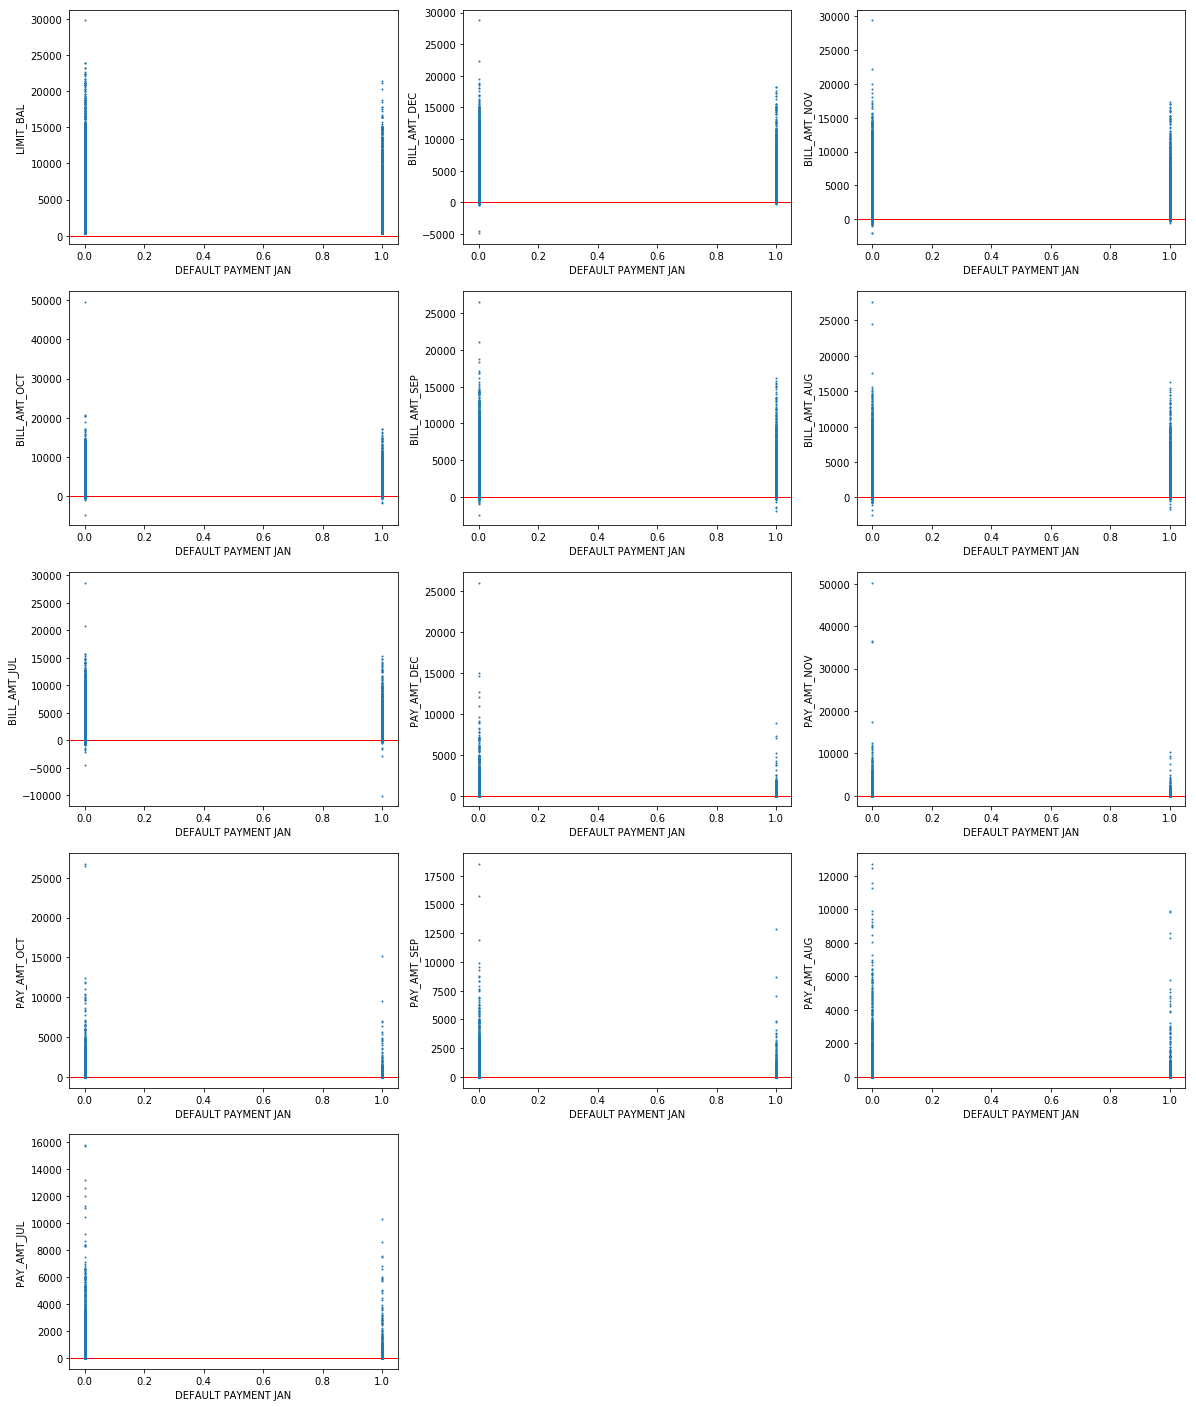

In [5]:
fig = plt.figure(figsize=(20,25))
fields = ['LIMIT_BAL',
              'BILL_AMT_DEC', 'BILL_AMT_NOV', 'BILL_AMT_OCT', 'BILL_AMT_SEP', 'BILL_AMT_AUG', 'BILL_AMT_JUL',
              'PAY_AMT_DEC', 'PAY_AMT_NOV', 'PAY_AMT_OCT', 'PAY_AMT_SEP', 'PAY_AMT_AUG', 'PAY_AMT_JUL']
# 13 fields
i = 1
for col_name in fields:
    ax = fig.add_subplot(5,3,i)
    i += 1
    ax.set_xlabel('DEFAULT PAYMENT JAN')
    ax.set_ylabel(col_name)
    ax.scatter(orig_dataset['DEFAULT PAYMENT JAN'], orig_dataset[col_name], s=1)
    ax.axhline(y=0, c='red', linewidth=1, zorder=0)
plt.show() 

                0     1
PAY_AUG_0   12307  2870
PAY_JUL_0   11834  2747
PAY_SEP_0   12022  2707
PAY_OCT_0   11624  2476
PAY_NOV_0   11825  2252
PAY_NOV_2    1581  1957
PAY_OCT_2    1679  1748
PAY_DEC_0   11490  1694
PAY_DEC_2     740  1659
PAY_SEP_2    1371  1474
PAY_AUG_2    1082  1272
PAY_JUL_2    1214  1252
PAY_DEC_1    2195  1114
PAY_JUL_-1   4291   885
PAY_JUL_-2   3507   870
PAY_NOV_-1   4561   863
PAY_DEC_-1   4249   848
PAY_OCT_-1   4501   832
PAY_SEP_-1   4289   816
PAY_AUG_-1   4176   805
PAY_AUG_-2   3267   793
PAY_SEP_-2   3147   742
PAY_OCT_-2   2992   674
PAY_NOV_-2   2777   615
PAY_DEC_-2   2151   327
PAY_DEC_3      69   222
PAY_NOV_3     108   174
PAY_OCT_3      92   131
PAY_JUL_3      59   108
PAY_AUG_3      60   105
...           ...   ...
PAY_SEP_4      19    40
PAY_OCT_4      29    39
PAY_JUL_7       8    35
PAY_JUL_4      17    27
PAY_OCT_7       5    20
PAY_SEP_5      15    15
PAY_NOV_5       9    14
PAY_JUL_6       4    13
PAY_DEC_5      12    11
PAY_OCT_6       

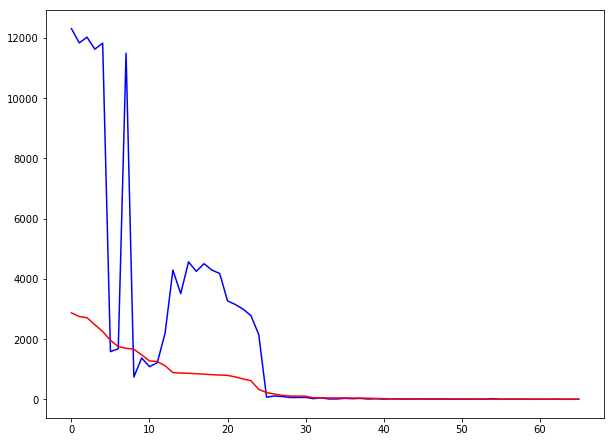

In [56]:
fields = ['PAY_DEC', 'PAY_NOV', 'PAY_OCT', 'PAY_SEP', 'PAY_AUG', 'PAY_JUL']
df = pd.DataFrame()
for field in fields:
    for j in [0]:
        for i in np.arange(-2,9):
            df['{}_{}'.format(field, i, j)] = (orig_dataset[field] == i) & (orig_dataset['DEFAULT PAYMENT JAN'] == j)
df1 = pd.DataFrame(df.sum())

df2 = pd.DataFrame()
for field in fields:
    for j in [1]:
        for i in np.arange(-2,9):
            df2['{}_{}'.format(field, i, j)] = (orig_dataset[field] == i) & (orig_dataset['DEFAULT PAYMENT JAN'] == j)
df3 = pd.DataFrame(df2.sum())
df3.rename(columns={0: 1}, inplace=True)

df9999 = pd.concat([df1, df3], axis=1).sort_values([1], ascending = 0)
#df9999.head(10000)
print(df9999.head(100))
fig = plt.figure()
plt.plot(df9999[0].tolist(), c='b')
plt.plot(df9999[1].tolist(), c='r')
plt.show()

# Preliminary Tests

In [101]:
X, y, X_test, y_test = retrieve_dataset(name='orig')

y_pred = X_test['PAY_AMT_DEC'] < X_test['BILL_AMT_DEC']
print(confusion_matrix(y_test, y_pred))
print(f1_score(y_test, y_pred))

y_pred = (X_test['PAY_DEC'] > 0)
y_pred &= (X_test['PAY_AMT_DEC'] < X_test['BILL_AMT_DEC'] + 1000)
y_pred &= (X_test['PAY_AMT_NOV'] < X_test['BILL_AMT_NOV'] + 1000)
y_pred &= (X_test['PAY_AMT_OCT'] < X_test['BILL_AMT_OCT'] + 1000)
print(confusion_matrix(y_test, y_pred))
print(f1_score(y_test, y_pred))

y_pred = (X_test['PAY_DEC'] > 0)
y_pred &= (X_test['PAY_NOV'] > 0)
y_pred &= (X_test['PAY_OCT'] > 0)
print(confusion_matrix(y_test, y_pred))
print(f1_score(y_test, y_pred))

# plt.figure()
# print(confusion_matrix(X['PAY_AMT_DEC'] < X['BILL_AMT_DEC'],
#                                  X['PAY_AMT_NOV'] < X['BILL_AMT_NOV']))
# print(confusion_matrix(X['PAY_AMT_NOV'] < X['BILL_AMT_NOV'],
#                                  X['PAY_AMT_OCT'] < X['BILL_AMT_OCT']))
# print(confusion_matrix(X['PAY_AMT_OCT'] < X['BILL_AMT_OCT'],
#                                  X['PAY_AMT_AUG'] < X['BILL_AMT_AUG']))
# plt.scatter(X['DEFAULT PAYMENT JAN'], X['PAY_AMT_DEC'] < X['BILL_AMT_DEC'], s=1)

# plt.axhline(y=0, c='red', linewidth=1, zorder=0)
# plt.show()

[[1587 5323]
 [ 376 1586]]
0.357569608838
[[5949  961]
 [ 963  999]]
0.509433962264
[[6606  304]
 [1461  501]]
0.362125045175


# Different datasets management
- split_and_add
- add_dataset
- retrieve_dataset

In [58]:
# Format: {'name' : X_name}
X_dict = {}
# Format: {'name' : y_name}
y_dict = {}
# Format: {'name' : X_test_name}
X_test_dict = {}
# Format: {'name' : y_test_name}
y_test_dict = {}
names = set()

target_col_name = 'DEFAULT PAYMENT JAN'

def split_and_add(dataset, name):
    train, test = train_test_split(dataset, test_size=0.33, random_state=r, stratify=dataset[target_col_name])
    X = train.drop([target_col_name], 1)
    y = train[target_col_name].tolist()
    X_test = test.drop([target_col_name], 1)
    y_test = test[target_col_name].tolist()
    add_dataset(X, y, X_test, y_test, name)
    print('Train X shape: {}'.format(X.shape))
    print('Test X shape: {}'.format(X_test.shape))

def add_dataset(X, y, X_test, y_test, name):
    names.add(name)
    X_dict[name] = X
    y_dict[name] = y
    X_test_dict[name] = X_test
    y_test_dict[name] = y_test

def retrieve_dataset(name):
    return (X_dict[name], y_dict[name], X_test_dict[name], y_test_dict[name])

split_and_add(dataset=orig_dataset, name='orig')
split_and_add(dataset=orig_dataset.drop(['SEX', 'EDUCATION', 'MARRIAGE', 'BIRTH_DATE'], 1), name='baseline')

Train X shape: (18012, 23)
Test X shape: (8872, 23)
Train X shape: (18012, 19)
Test X shape: (8872, 19)


# Alessandro's dataset
- One hot encoding of SEX
- scores to MARRIAGE and EDUCATION
- BIRTH_DATE transformed to AGE and normalized
- Columns with money values like LIMIT_BAL and BILL_AMT_DEC normalized togheter to mean=0 std=1
- Delay in payments normalized togheter to mean=0 std=1

In [112]:
def transform_features(X_orig):
    X = X_orig.copy()
    print('One hot encoding SEX feature')
    # set(dataset["SEX"]) = {nan, 'M', 'F'}
    fields = {'SEX'}
    for field in fields:
        X = pd.concat([X.drop([field], 1), pd.get_dummies(X[field])], axis=1)

    print('Scoring EDUCATION and MARRIAGE features')
    # Assume other == Nan
    # set(dataset["EDUCATION"]) = {nan, 'high school', 'graduate school', 'other', 'university'}
    # set(dataset["MARRIAGE"]) = {nan, 'other', 'single', 'married'}
    education_dict = { 'other': 0, 'high school': 0.1, 'university': 0.5, 'graduate school': 1}
    marriage_dict = {'other': 0, 'single': 0.1, 'married': 1}
    X['EDUCATION'] = X['EDUCATION'].fillna('other').apply(lambda x: education_dict[x])
    X['MARRIAGE'] = X['MARRIAGE'].fillna('other').apply(lambda x: marriage_dict[x])

    print('Computing AGE and dropping BIRTH_DATE')
    X['BIRTH_DATE'] = pd.to_datetime(X['BIRTH_DATE'], format='%d/%m/%Y')
    
    def calculate_age(birth_date):
        today = date.today()
        age = today.year - birth_date.year
        full_year_passed = (today.month, today.day) < (birth_date.month, birth_date.day)
        if not full_year_passed:
            age -= 1
        return age
    X['AGE'] = X['BIRTH_DATE'].apply(lambda x: calculate_age(x))
    X = X.drop(["BIRTH_DATE"], 1)
    X['AGE'] = X['AGE'].fillna(X['AGE'].mean())

    fields = ['LIMIT_BAL',
              'BILL_AMT_DEC', 'BILL_AMT_NOV', 'BILL_AMT_OCT', 'BILL_AMT_SEP', 'BILL_AMT_AUG', 'BILL_AMT_JUL',
              'PAY_AMT_DEC', 'PAY_AMT_NOV', 'PAY_AMT_OCT', 'PAY_AMT_SEP', 'PAY_AMT_AUG', 'PAY_AMT_JUL']
    print('Normalizing {}'.format(fields))
    # np.cbrt is the only one that works with negative numbers
    # using pow with 1/3 or 1/5 etc with negative numbers leads to complex number as results because of
    # numerical approximations
    # np.cbrt instead apply the direct algorithm to find cubic root, which is well defined for every negative number
    X[fields] = X[fields].apply(lambda x: x.apply(lambda y: np.cbrt(y)))
    #max_euro = dataset[fields].max().max()
    #min_euro = dataset[fields].min().min()
    #dataset[fields] = dataset[fields].apply(lambda x: x.apply(lambda y: (y-min_euro)/(max_euro-min_euro)))

    fields = ['PAY_DEC', 'PAY_NOV', 'PAY_OCT', 'PAY_SEP', 'PAY_AUG', 'PAY_JUL']
    print('Normalizing {}'.format(fields))
    X[fields] = X[fields].apply(lambda x : x.apply(lambda y : (y + 2) / 10))

    print('Normalizing AGE')
    min_age = X['AGE'].min()
    max_age = X['AGE'].max()
    X['AGE'] = X['AGE'].apply(lambda x: (x - min_age) / (max_age - min_age))
    
    for month in ['_JUL', '_AUG', '_SEP', '_OCT', '_NOV', '_DEC']:
        X['BILL_AMT_MINUS_PAY_AMT{}'.format(month)] = X['BILL_AMT{}'.format(month)] - X['PAY_AMT{}'.format(month)]
        
    #for month in ['_JUL', '_AUG', '_SEP', '_OCT', '_NOV', '_DEC']:
     #   X['PAY_POSITIVE_{}'.format(month)] = (X['PAY{}'.format(month)] > 0).apply(lambda x : 1 if x == True else 0)
    #X = X.drop(fields, axis=1)   
    
    print('Dataset prepared')
    print(dataset.shape)
    
    return X.copy()

In [113]:
X, y, X_test, y_test = retrieve_dataset(name='orig')
add_dataset(transform_features(X), y, transform_features(X_test), y_test, 'ale')
X, y, X_test, y_test = retrieve_dataset(name='ale')
X.head(5)

One hot encoding SEX feature
Scoring EDUCATION and MARRIAGE features
Computing AGE and dropping BIRTH_DATE
Normalizing ['LIMIT_BAL', 'BILL_AMT_DEC', 'BILL_AMT_NOV', 'BILL_AMT_OCT', 'BILL_AMT_SEP', 'BILL_AMT_AUG', 'BILL_AMT_JUL', 'PAY_AMT_DEC', 'PAY_AMT_NOV', 'PAY_AMT_OCT', 'PAY_AMT_SEP', 'PAY_AMT_AUG', 'PAY_AMT_JUL']
Normalizing ['PAY_DEC', 'PAY_NOV', 'PAY_OCT', 'PAY_SEP', 'PAY_AUG', 'PAY_JUL']
Normalizing AGE
Dataset prepared
(26884, 24)
One hot encoding SEX feature
Scoring EDUCATION and MARRIAGE features
Computing AGE and dropping BIRTH_DATE
Normalizing ['LIMIT_BAL', 'BILL_AMT_DEC', 'BILL_AMT_NOV', 'BILL_AMT_OCT', 'BILL_AMT_SEP', 'BILL_AMT_AUG', 'BILL_AMT_JUL', 'PAY_AMT_DEC', 'PAY_AMT_NOV', 'PAY_AMT_OCT', 'PAY_AMT_SEP', 'PAY_AMT_AUG', 'PAY_AMT_JUL']
Normalizing ['PAY_DEC', 'PAY_NOV', 'PAY_OCT', 'PAY_SEP', 'PAY_AUG', 'PAY_JUL']
Normalizing AGE
Dataset prepared
(26884, 24)


,LIMIT_BAL,EDUCATION,MARRIAGE,PAY_DEC,PAY_NOV,PAY_OCT,PAY_SEP,PAY_AUG,PAY_JUL,BILL_AMT_DEC,...,PAY_AMT_JUL,F,M,AGE,BILL_AMT_MINUS_PAY_AMT_JUL,BILL_AMT_MINUS_PAY_AMT_AUG,BILL_AMT_MINUS_PAY_AMT_SEP,BILL_AMT_MINUS_PAY_AMT_OCT,BILL_AMT_MINUS_PAY_AMT_NOV,BILL_AMT_MINUS_PAY_AMT_DEC
CUST_COD,,,,,,,,,,,,,,,,,,,,,
14356766,13.360872,0.5,0.1,0.3,0.4,0.4,0.4,0.4,0.0,4.951950,...,0.000000,1,0,0.111111,0.000000,0.000000,6.162301,5.374123,-0.253943,4.951950
21308338,8.416822,1.0,0.1,0.2,0.2,0.2,0.2,0.2,0.2,7.777672,...,3.100784,1,0,0.037037,5.327106,5.800257,5.335632,4.785578,4.527438,2.475407
54049646,17.507695,0.1,1.0,0.2,0.2,0.2,0.2,0.2,0.2,14.005143,...,4.569354,1,0,0.518519,9.062446,9.334947,8.549043,9.592163,8.721246,9.127660
10396398,9.634856,0.1,0.1,0.1,0.1,0.0,0.0,0.0,0.0,2.706525,...,0.000000,1,0,0.537037,0.000000,0.000000,0.000000,0.000000,0.000000,2.706525
11528589,14.857157,0.5,1.0,0.2,0.2,0.2,0.2,0.2,0.2,11.382419,...,4.472104,0,1,0.333333,5.748034,4.969845,5.843519,5.625451,6.164058,6.906839


In [6]:
X.describe().round(3)

,LIMIT_BAL,EDUCATION,MARRIAGE,PAY_DEC,PAY_NOV,PAY_OCT,PAY_SEP,PAY_AUG,PAY_JUL,BILL_AMT_DEC,...,BILL_AMT_JUL,PAY_AMT_DEC,PAY_AMT_NOV,PAY_AMT_OCT,PAY_AMT_SEP,PAY_AMT_AUG,PAY_AMT_JUL,F,M,AGE
count,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,...,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000
mean,15.837,0.603,0.505,0.199,0.187,0.184,0.179,0.174,0.172,8.935,...,7.692,4.042,4.000,3.738,3.561,3.532,3.524,0.595,0.396,0.268
std,4.610,0.328,0.449,0.112,0.119,0.120,0.118,0.114,0.116,5.485,...,5.456,2.693,2.769,2.733,2.729,2.706,2.868,0.491,0.489,0.168
min,6.680,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-17.027,...,-21.634,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,11.423,0.500,0.100,0.100,0.100,0.100,0.100,0.100,0.100,4.830,...,3.341,3.101,2.913,2.265,2.042,1.956,1.489,0.000,0.000,0.130
50%,16.101,0.500,0.100,0.200,0.200,0.200,0.200,0.200,0.200,8.856,...,8.017,3.971,3.916,3.791,3.550,3.550,3.550,1.000,0.000,0.241
75%,19.270,1.000,1.000,0.200,0.200,0.200,0.200,0.200,0.200,12.646,...,11.391,5.304,5.302,5.119,4.925,4.930,4.922,1.000,1.000,0.370
max,28.172,1.000,1.000,1.000,0.900,1.000,0.900,0.900,1.000,28.133,...,25.057,24.693,33.197,24.745,23.443,23.184,25.073,1.000,1.000,1.000


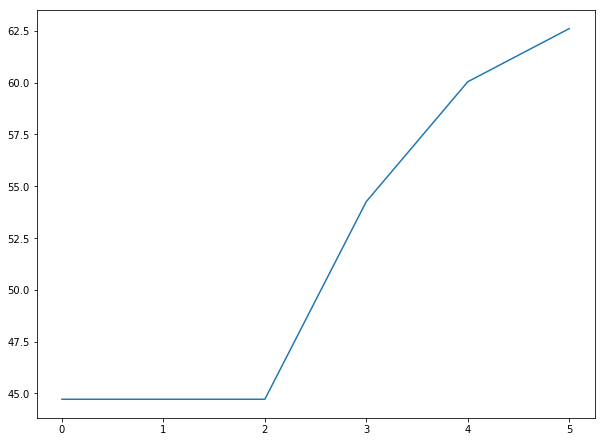

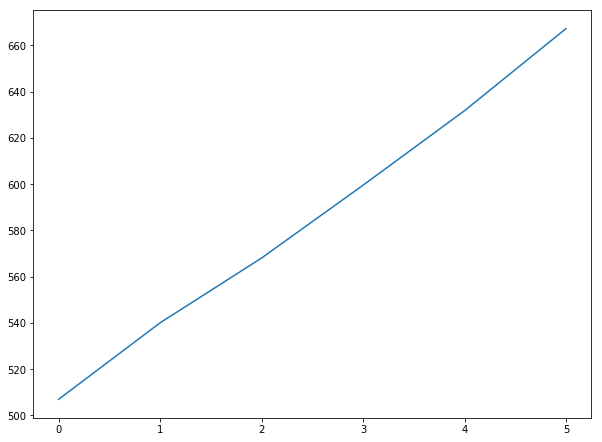

In [17]:
X = orig_dataset
m = [X['PAY_AMT_JUL'].median(),
     X['PAY_AMT_AUG'].median(),
     X['PAY_AMT_SEP'].median(),
     X['PAY_AMT_OCT'].median(),
     X['PAY_AMT_NOV'].median(),
     X['PAY_AMT_DEC'].median()]

plt.figure()
plt.plot(m)
plt.show()

m = [X['BILL_AMT_JUL'].median(),
     X['BILL_AMT_AUG'].median(),
     X['BILL_AMT_SEP'].median(),
     X['BILL_AMT_OCT'].median(),
     X['BILL_AMT_NOV'].median(),
     X['BILL_AMT_DEC'].median()]

plt.figure()
plt.plot(m)
plt.show()


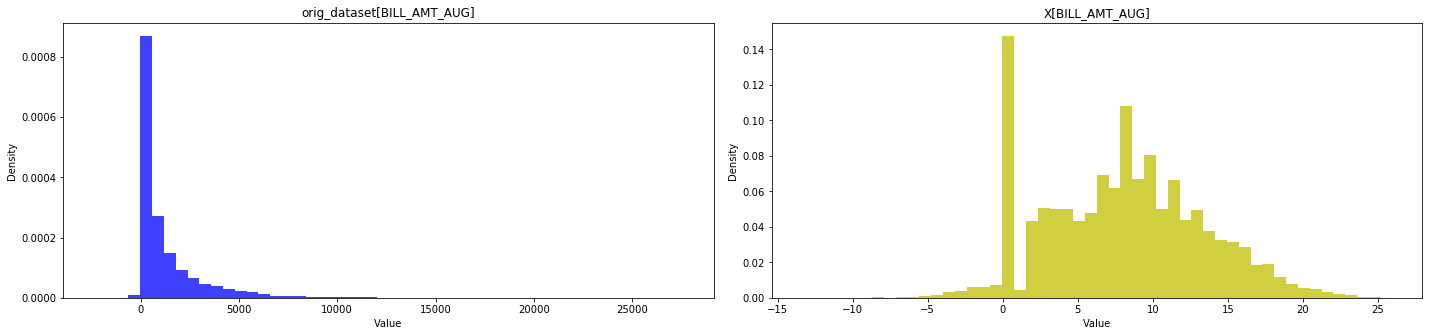

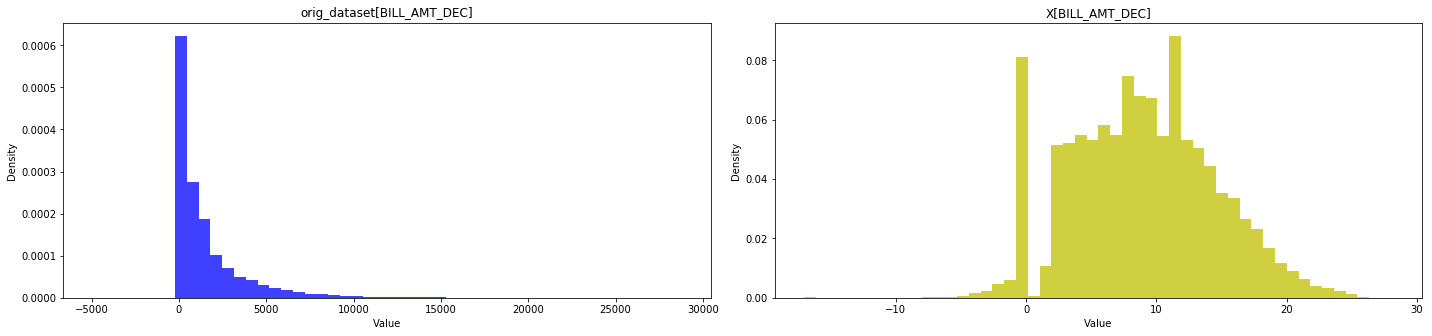

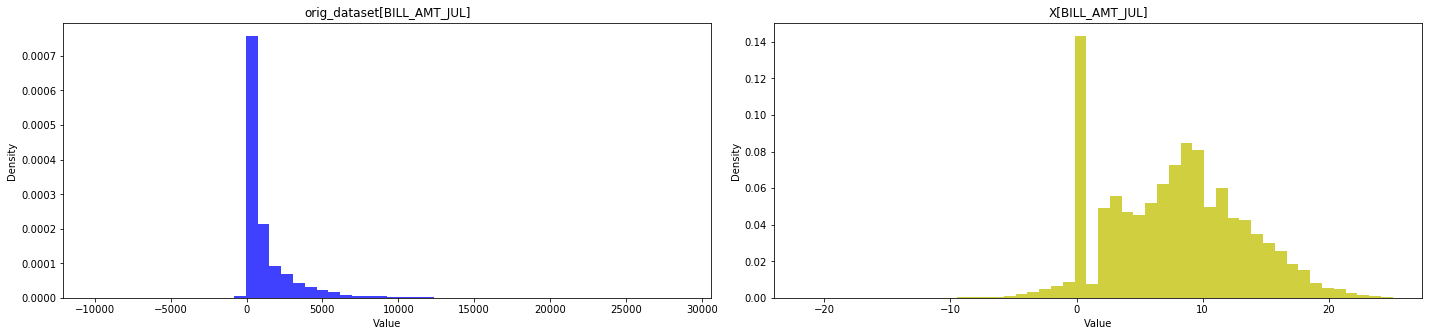

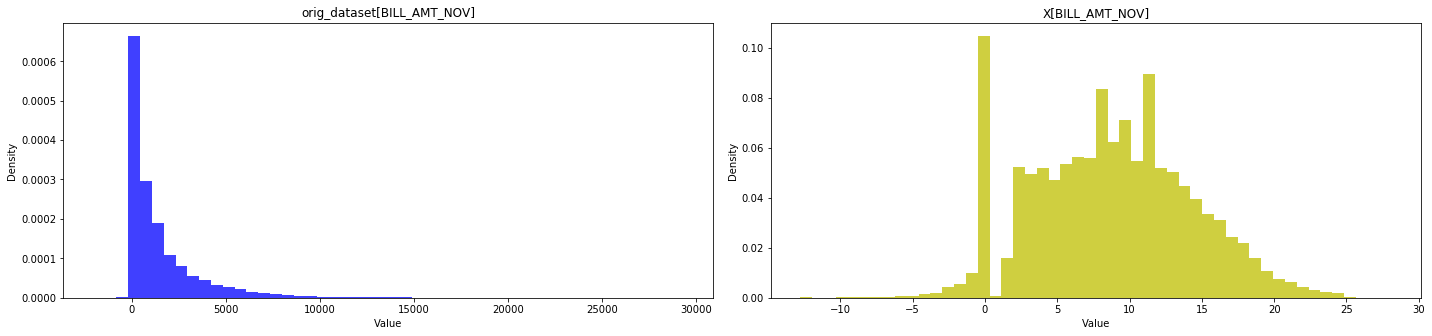

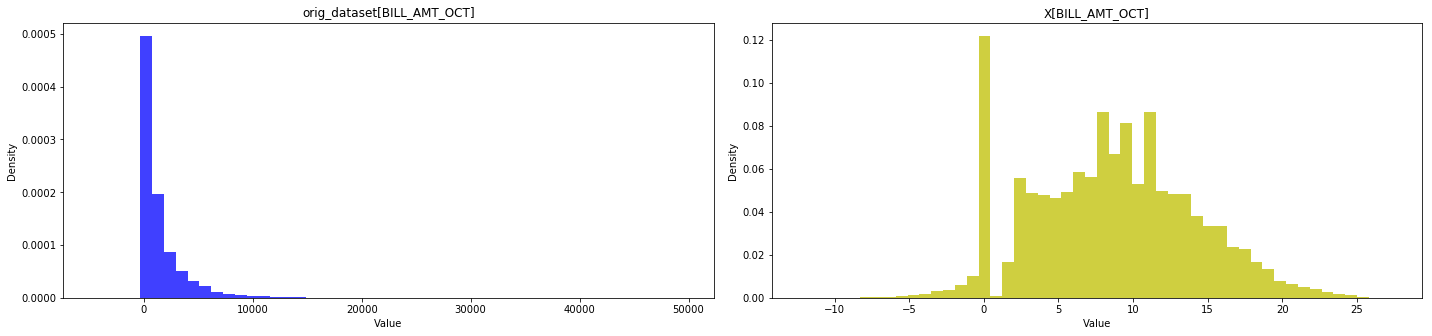

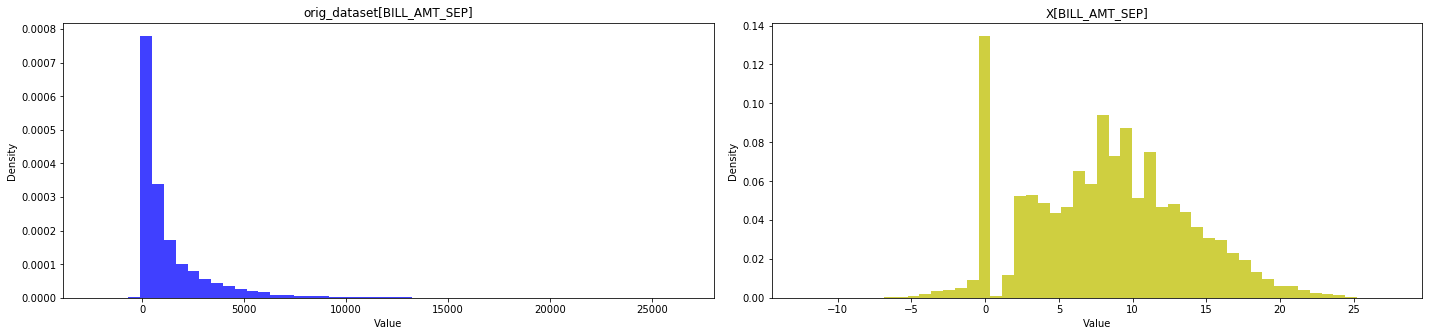

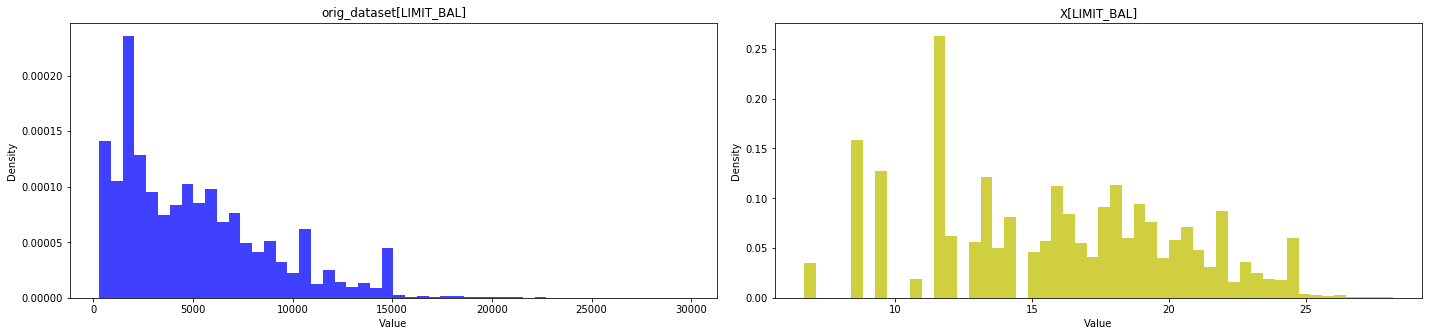

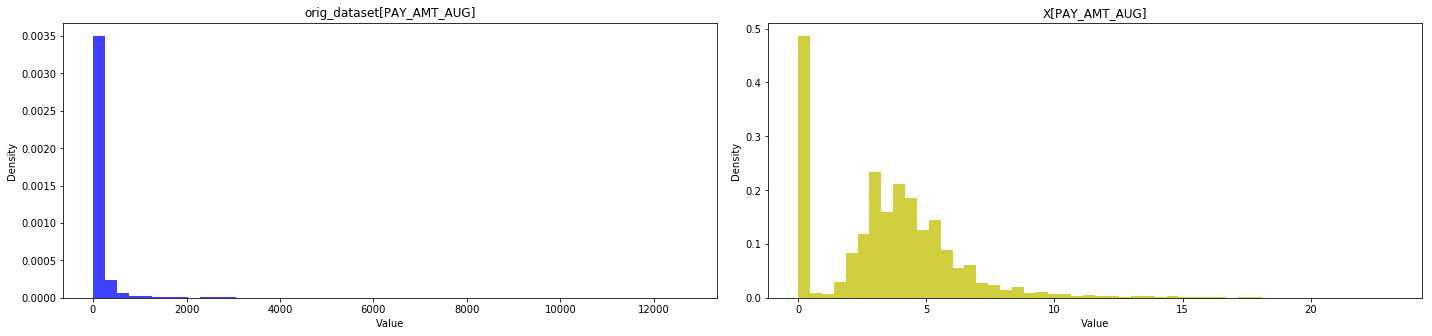

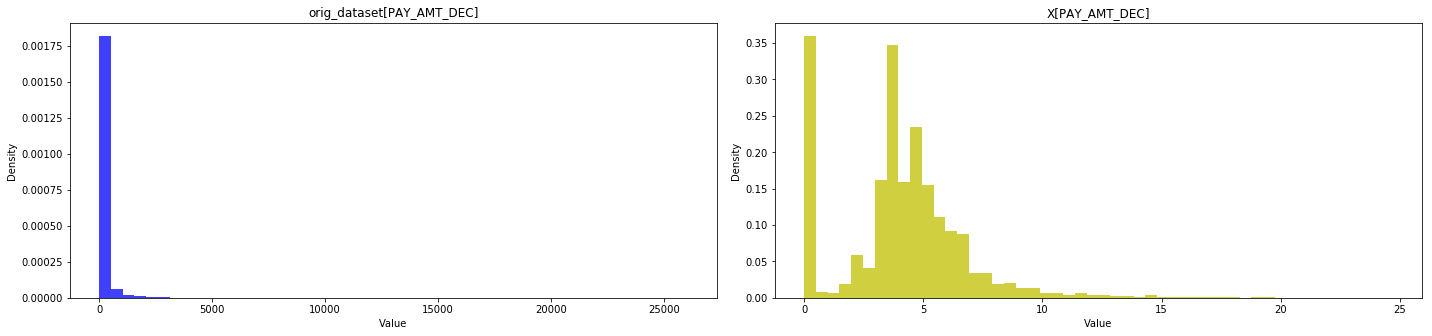

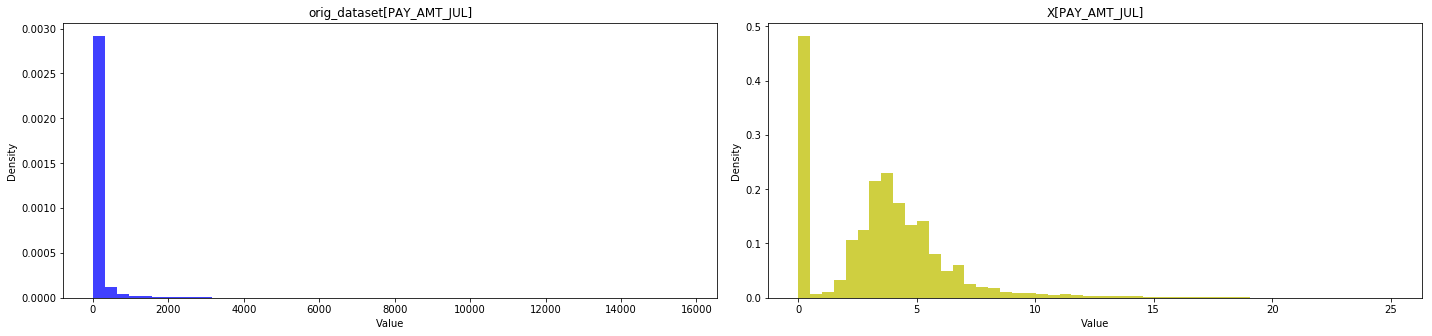

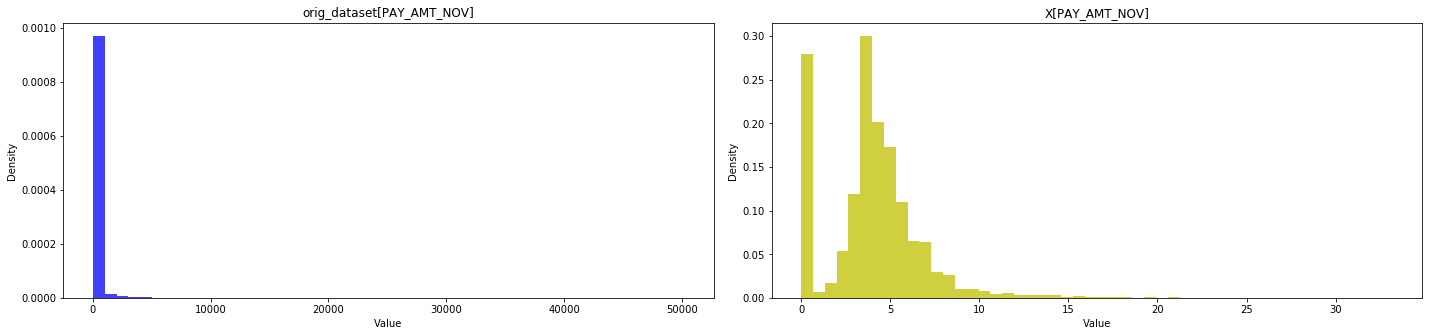

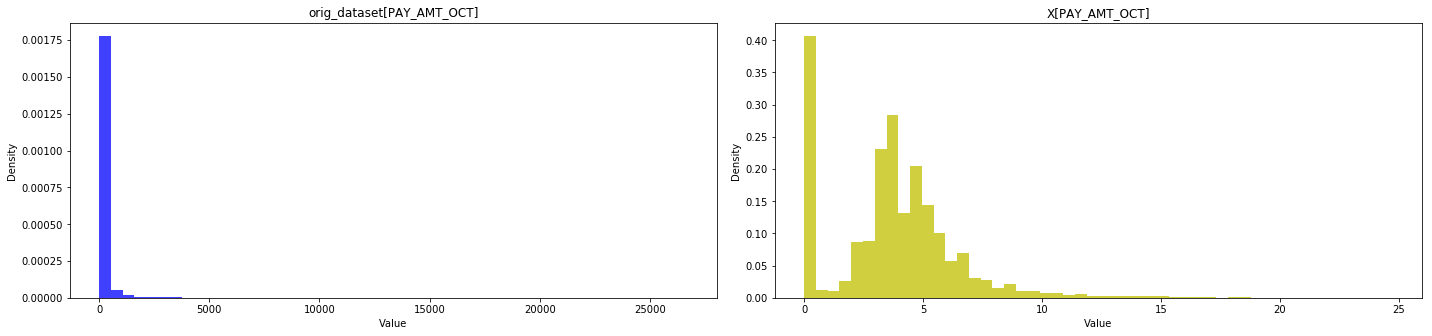

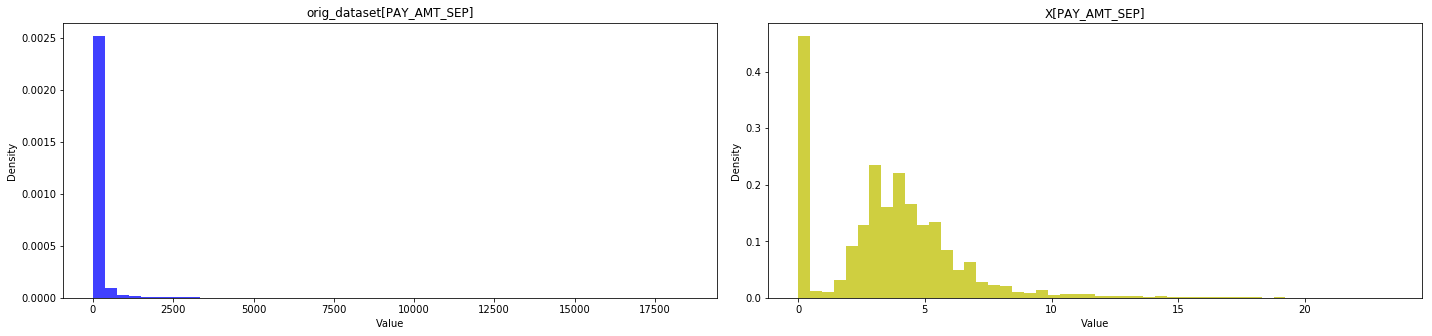

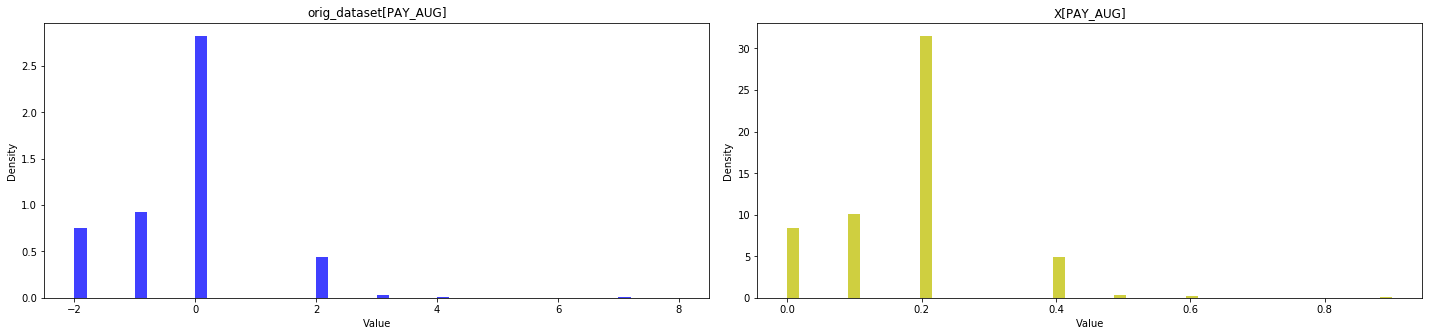

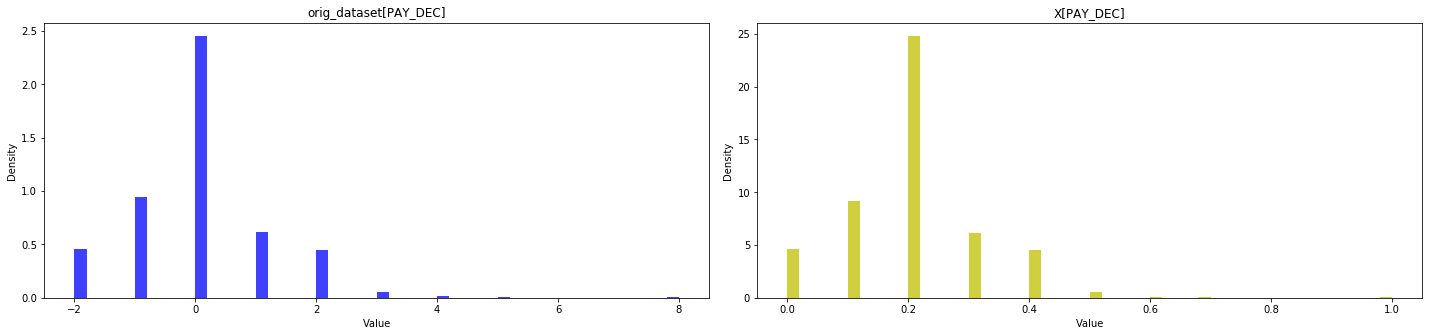

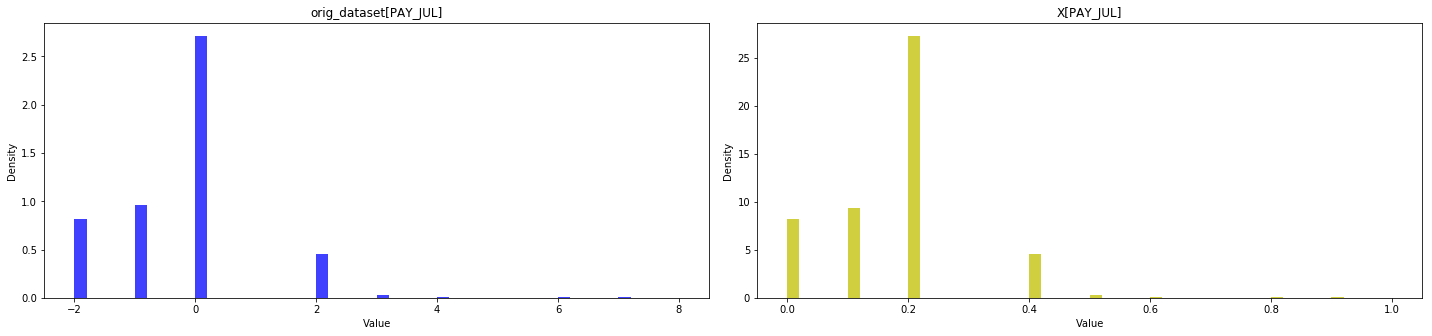

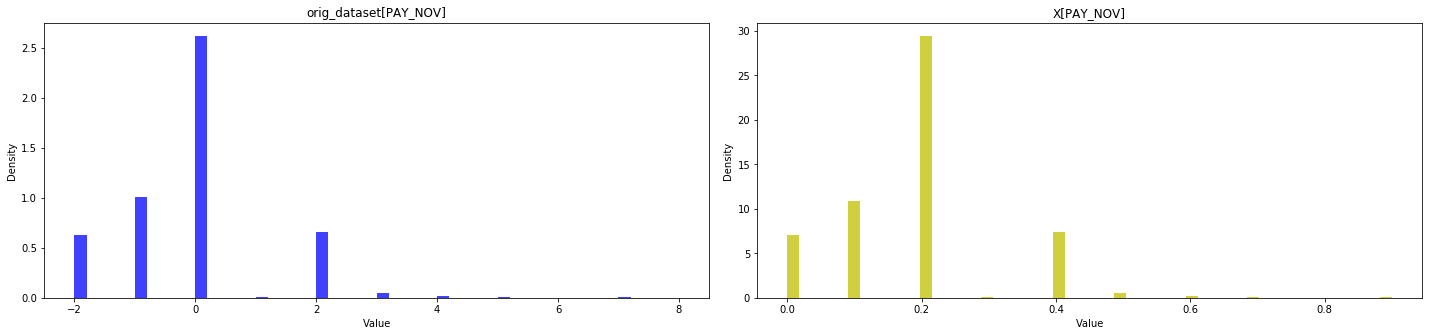

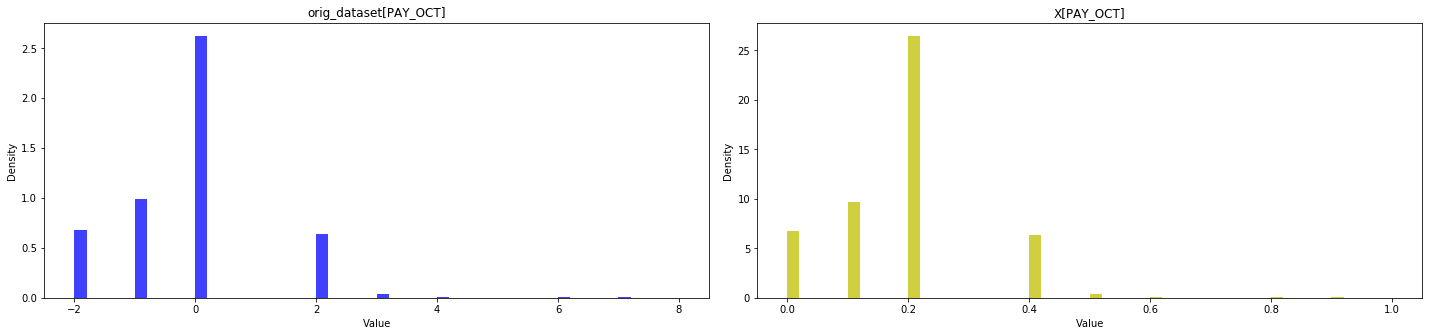

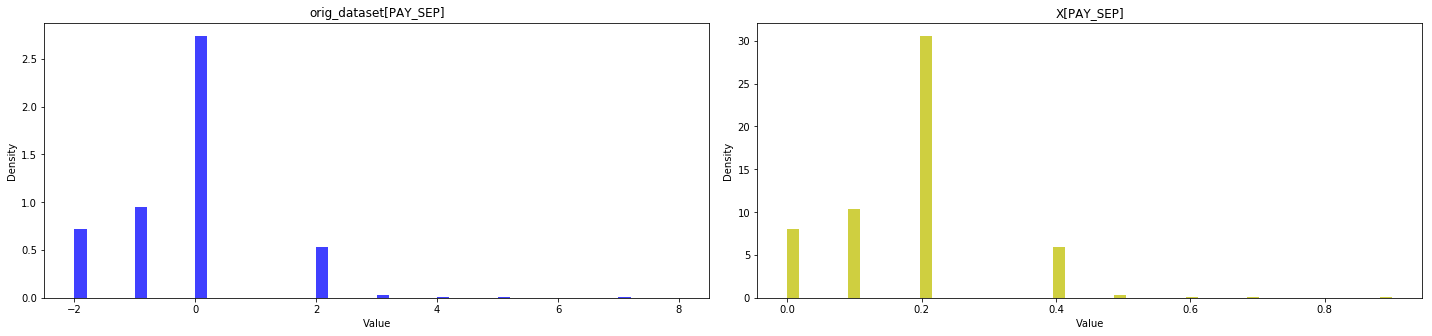

In [10]:
for col_name in sorted(set(X.columns).intersection(set(orig_dataset.columns))):
    if (col_name in {'EDUCATION', 'MARRIAGE', 'SEX'}):
        continue
    fig, axarr = plt.subplots(1, 2, figsize=(20,5))
    axarr[0].hist(orig_dataset[col_name], 50, normed=1, facecolor='b', alpha=0.75)
    axarr[0].set_xlabel('Value')
    axarr[0].set_ylabel('Density')
    axarr[0].set_title('orig_dataset[{}]'.format(col_name))

    axarr[1].hist(X[col_name], 50, normed=1, facecolor='y', alpha=0.75)
    axarr[1].set_xlabel('Value')
    axarr[1].set_ylabel('Density')
    axarr[1].set_title('X[{}]'.format(col_name))

    fig.tight_layout()
    fig.subplots_adjust(top=0.88)

    plt.show()


# Alessandro's - PCA

Printing PCA with 3 components to visualize dataset


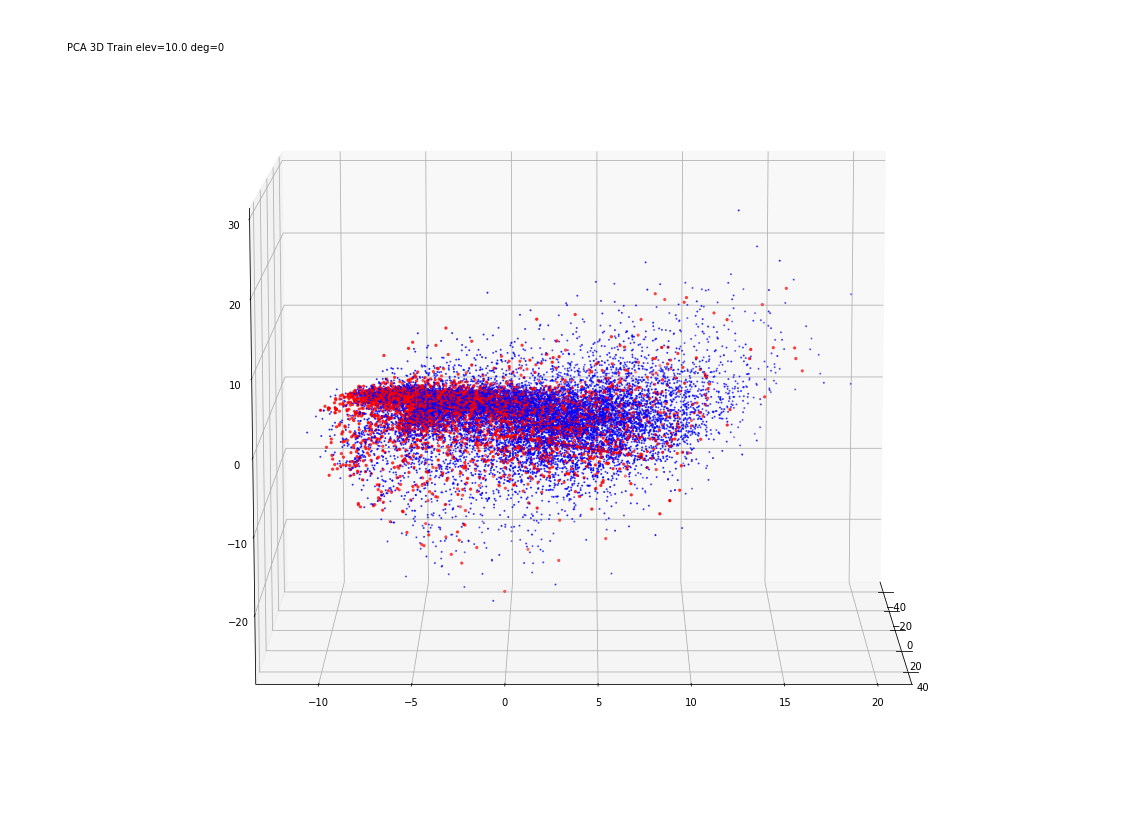

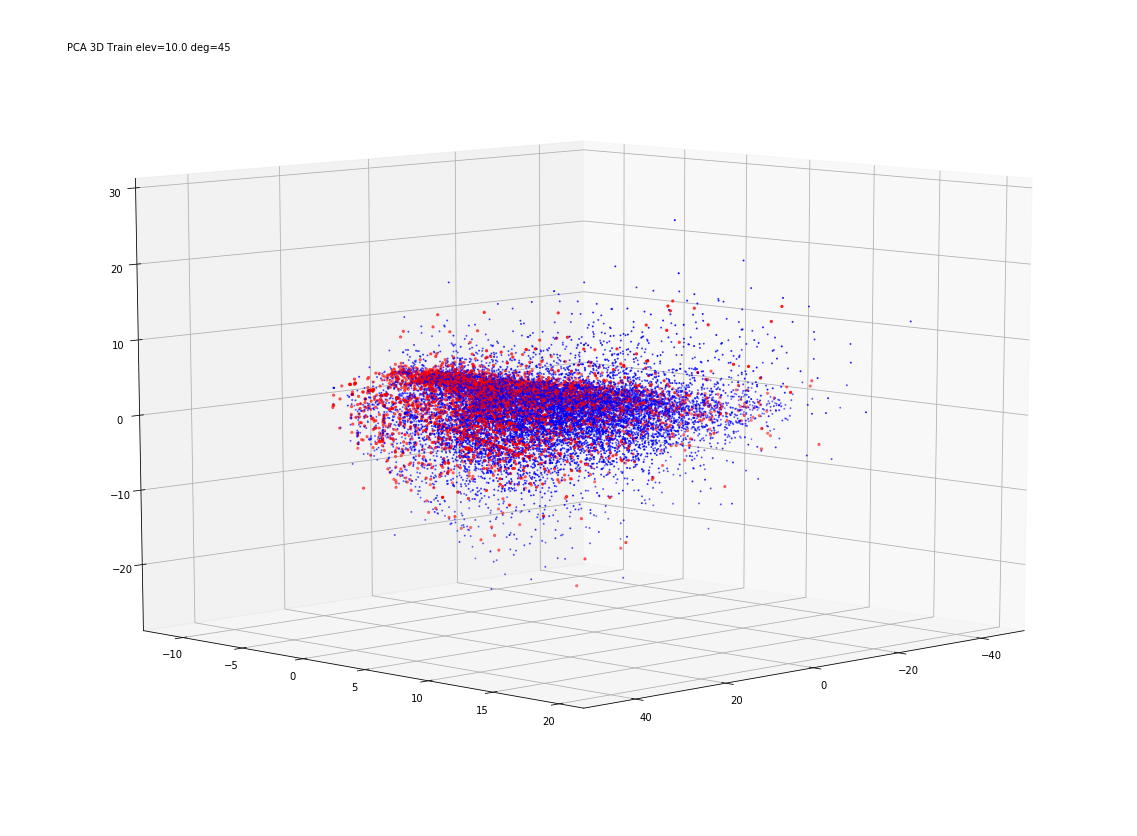

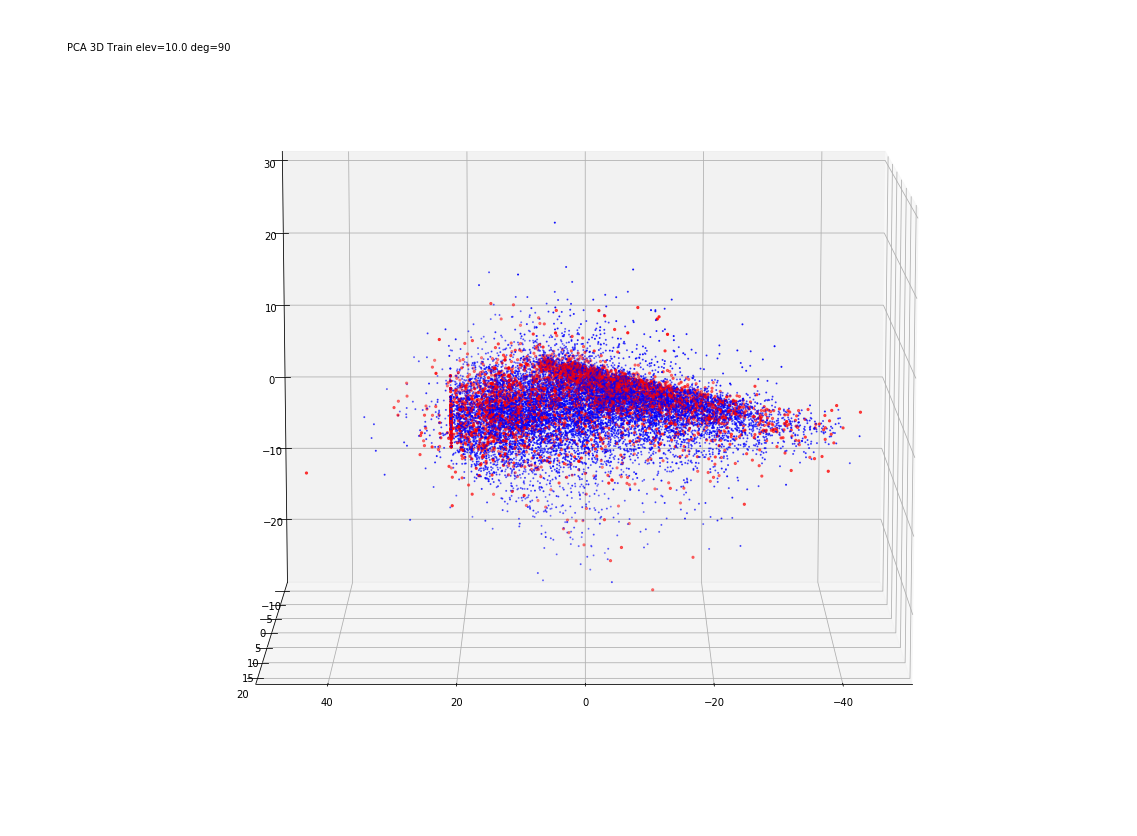

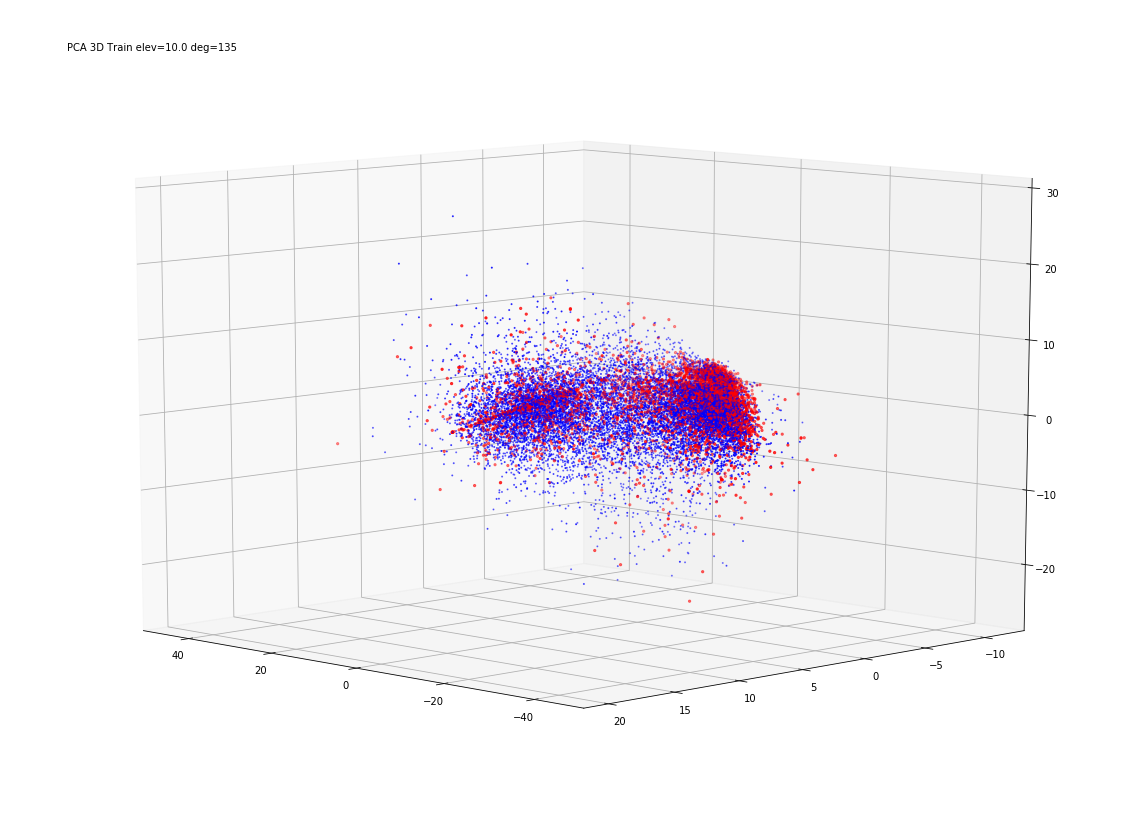

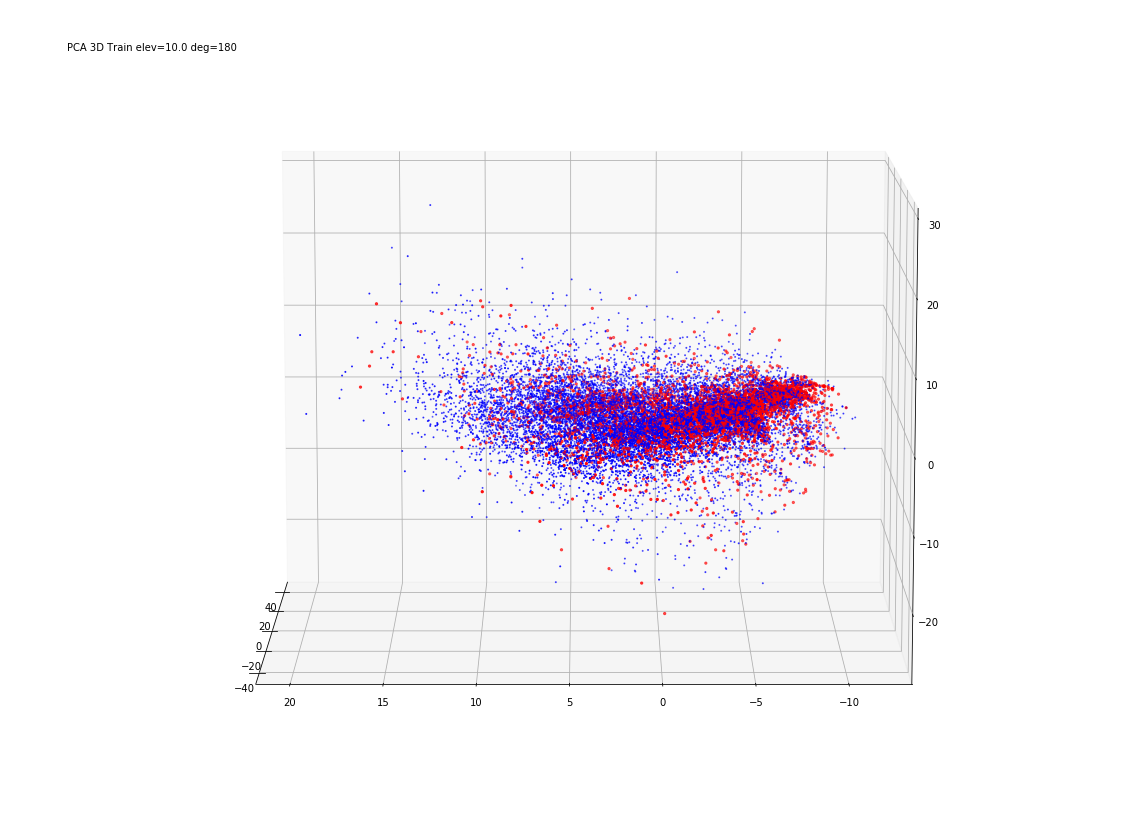

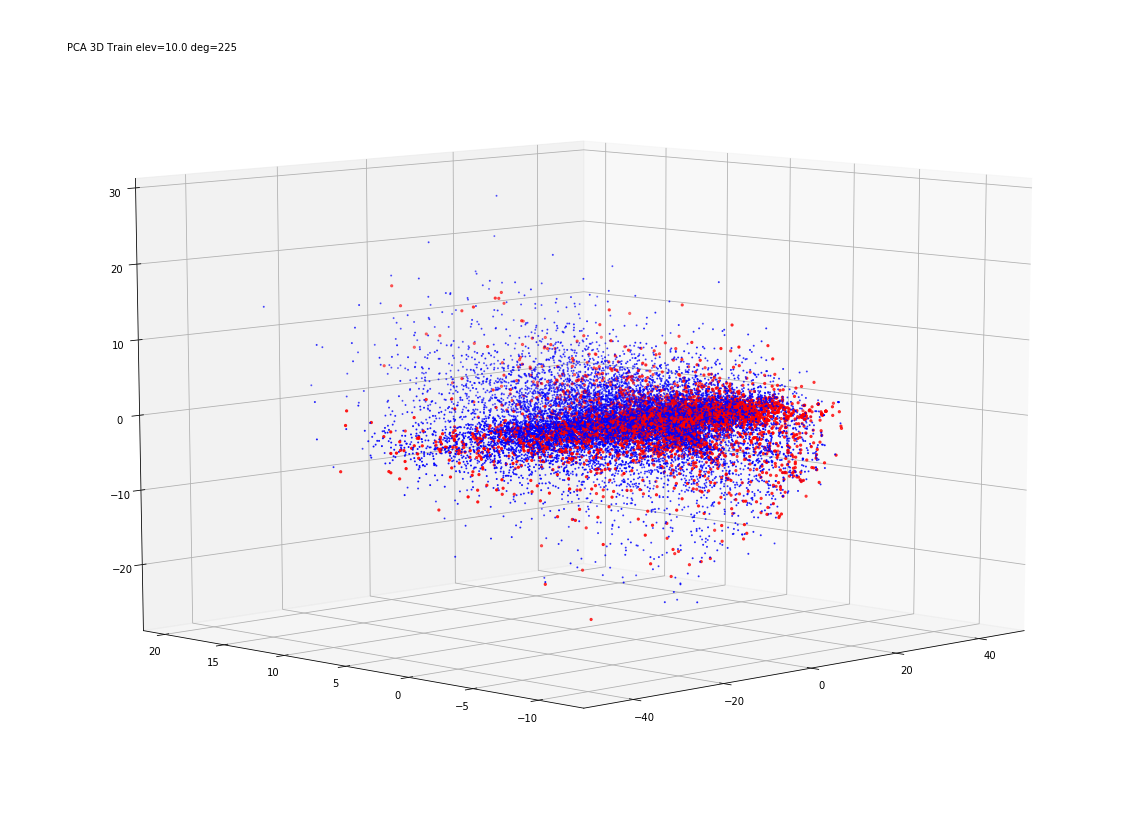

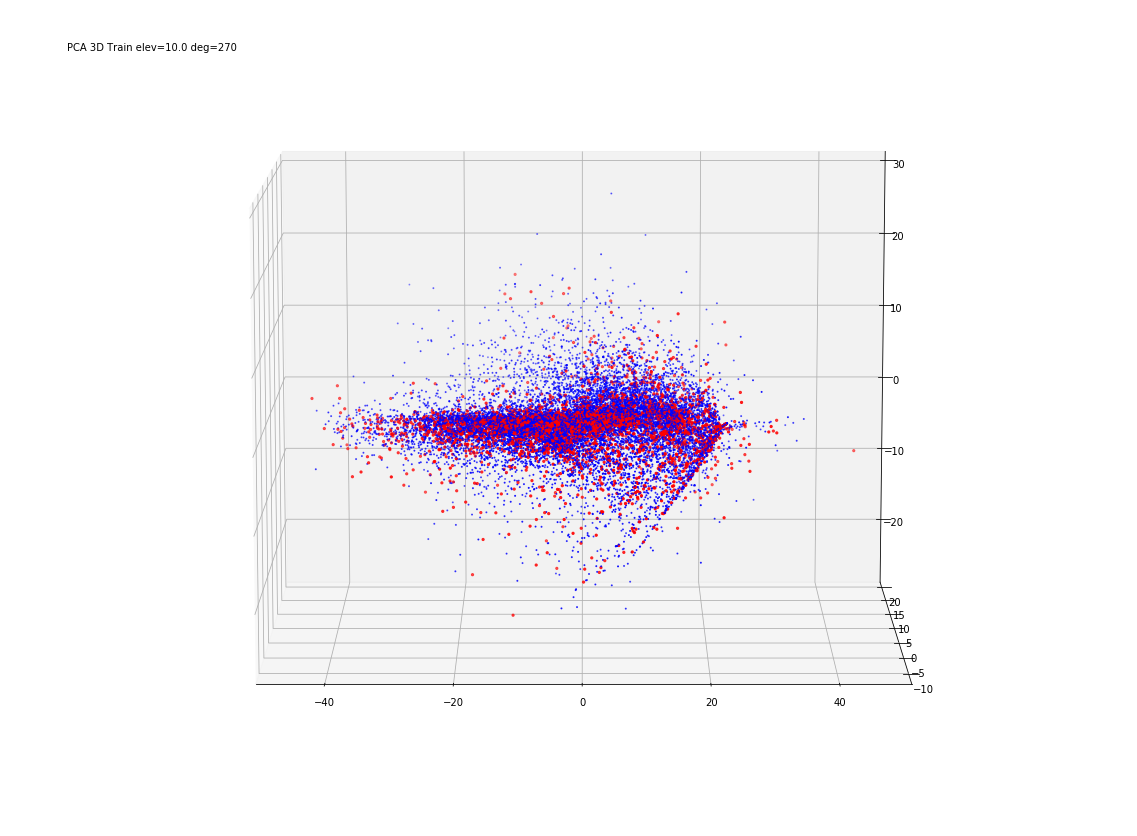

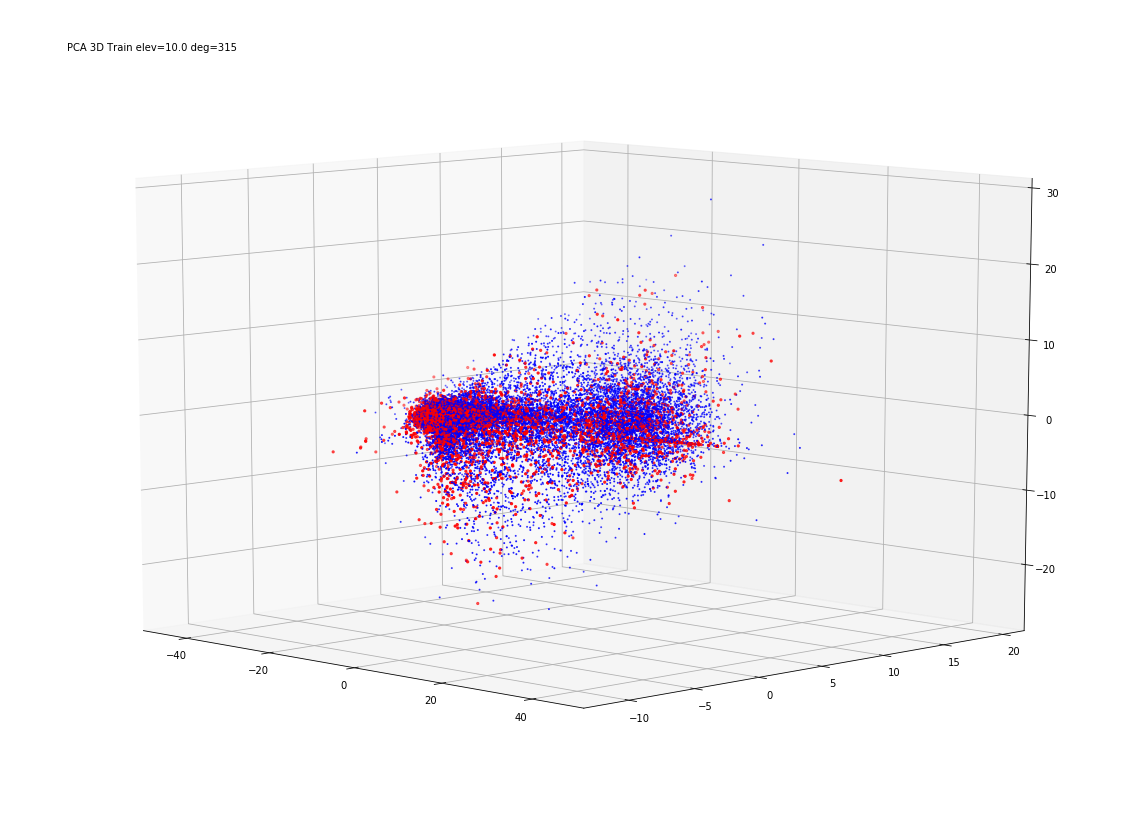

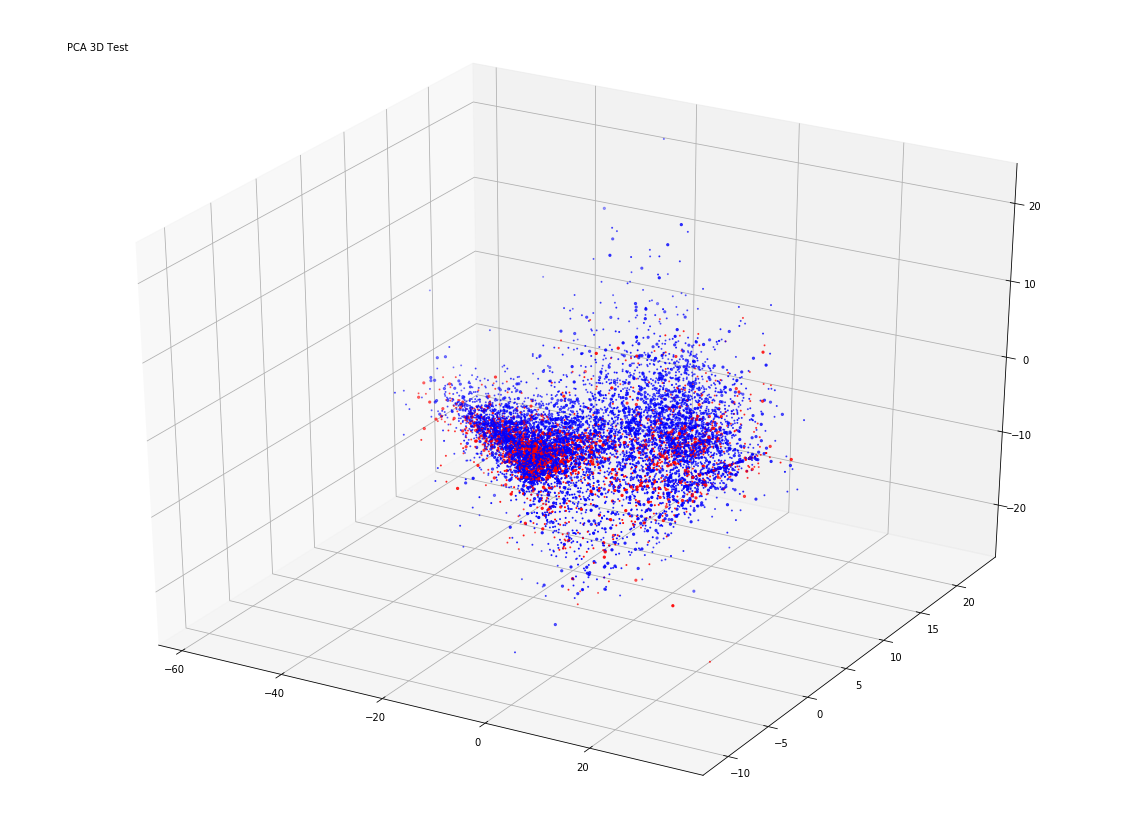

In [329]:
from sklearn.decomposition import PCA
name = 'ale'
X, y, X_test, y_test = retrieve_dataset(name)

print('Printing PCA with 3 components to visualize dataset')
pca = PCA(whiten=False, random_state=r, n_components=3)
pca.fit(X)
colors = {0: 'b', 1: 'r'}
sizes = {0: 1, 1: 5}

df = pd.DataFrame(pca.transform(X))

#fig = plt.figure()
# fig, axarr = plt.subplots(nrows=4, ncols=5, figsize=(20,5), projection='3d')
for ii in np.arange(0,360,45):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.text2D(0.05, 0.95, 'PCA 3D Train elev={} deg={}'.format(10., ii), transform=ax.transAxes)
    ax.view_init(elev=10., azim=ii)
    ax.scatter(df[0], df[1], df[2], c=pd.DataFrame(y)[0].apply(lambda x: colors[x]), s=pd.DataFrame(y)[0].apply(lambda x: sizes[x]))
    plt.show()
    
df = pd.DataFrame(pca.transform(X_test))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.text2D(0.05, 0.95, 'PCA 3D Test', transform=ax.transAxes)
ax.scatter(df[0], df[1], df[2], c=pd.DataFrame(y_test)[0].apply(lambda x: colors[x]), s=pd.DataFrame(y)[0].apply(lambda x: sizes[x]))
plt.show()

# PCA

In [89]:
pca_enabled = False
if pca_enabled:
    X, y, X_test, y_test = retrieve_dataset('ale')
    print('Starting PCA')
    pca = PCA(whiten=False, random_state=r)
    pca.fit(X)
    cumsum = sorted(list(pca.explained_variance_ratio_.cumsum()))
 
    def find_cumsum_tresh(cumsum, cumsum_tresh):
        for i in np.arange(0, len(cumsum)):
            if cumsum[i] >= cumsum_tresh:
                break
        return i
    
    plt.figure(1)
    # plt.grid(color='k', linestyle='-', linewidth=0.5)
    plt.plot(cumsum, label='Cumsum', marker='o', color='b')
    plt.xlabel('N Components')
    plt.ylabel('Cumsum')
    plt.title('PCA Cumsum')
    plt.legend(loc='best')
    
    for i in [0.8, 0.85, 0.9, 0.95, 0.97, 0.99]:
        n_components = find_cumsum_tresh(cumsum, i)
        print('cumsum_tresh = {}, n_components = {}'.format(i, n_components))
        plt.axhline(y=i, c='red', linewidth=0.5, zorder=0)

    plt.show()
    
    tresh = 0.97
    
    n_components = find_cumsum_tresh(cumsum, tresh)
    print('Selecting tresh = {} -> n_components = {}'.format(tresh, n_components))
    pca = PCA(whiten=False, random_state=r, n_components=n_components)
    pca.fit(X)
    X_pca = pca.transform(X)
    X_pca_test = pca.transform(X_test)
    
    add_dataset(X_pca, y, X_pca_test, y_test, name+'_pca')

In [332]:
X, y, X_test, y_test = retrieve_dataset('ale_pca')
pd.DataFrame(X).head(5)

,0,1,2,3,4,5,6,7
0,12.767175,-3.778131,-3.818080,1.432339,-4.462569,-2.862083,0.248187,-1.369044
1,0.593168,-6.366213,3.086658,2.532358,0.593460,0.496720,0.051192,0.952054
2,-13.974568,0.311463,0.186513,-1.453534,-0.533674,-0.294333,-0.642491,0.157365
3,21.445754,-5.901817,0.503768,-1.373119,0.183507,0.045336,0.006363,-1.067387
4,-5.393926,-0.810860,0.905792,0.196202,1.077280,0.120054,0.415035,-0.545372


In [333]:
pd.DataFrame(X).describe().round(3)

,0,1,2,3,4,5,6,7
count,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000
mean,0.000,-0.000,0.000,0.000,-0.000,-0.000,0.000,0.000
std,12.895,4.936,3.691,2.948,2.636,2.392,2.350,2.269
min,-44.225,-11.136,-25.094,-15.171,-18.703,-15.152,-16.781,-18.090
25%,-8.438,-4.084,-1.648,-1.852,-1.245,-0.822,-0.793,-0.763
50%,0.547,-0.278,0.322,-0.257,-0.122,-0.090,0.011,0.054
75%,9.749,3.584,2.016,1.530,1.051,0.921,0.787,0.852
max,44.718,19.601,27.407,24.499,21.266,21.519,24.821,24.964


# CV and scoring functions

In [61]:
def cost_matrix(y, y_pred):
    cm = confusion_matrix(y, y_pred)
    # first index true
    # second index predicted
    return cm[0][0] * 0 + cm[0][1] * 1 + cm[1][0] * 5 + cm[1][1] * 0

def cv_clf(clf, X, y, X_test, y_test):
    y_pred = clf.predict(X)
    y_pred_test = clf.predict(X_test)
    scores_stkfold = cross_val_score(clf, X, y, scoring='f1', cv=cv)
    f1_cv_mean = scores_stkfold.mean()
    f1_cv_std = scores_stkfold.std()
    f1_train = f1_score(y, y_pred)  
    f1_test = f1_score(y_test, y_pred_test)
    print('f1_train = {:.3f}\t f1_cv = {:.3f} ± {:.3f}\nf1_test = {:.3f}'.format(f1_train, f1_cv_mean, f1_cv_std, f1_test))
    # cost_train = cost_matrix(y, y_pred)
    # cost_test = cost_matrix(y_test, y_pred_test)
    # print('cost_train = {}\ncost_test = {}'.format(format(cost_train, ','), format(cost_test, ',')))
    cm_train = confusion_matrix(y, y_pred)
    cm_test = confusion_matrix(y_test, y_pred_test)
    print('cm_train = \n{}\ncm_test = \n{}'.format(cm_train, cm_test))

def fit_and_score(clf, name):
    print('Evaluating on ' + name + ' dataset')
    X, y, X_test, y_test = retrieve_dataset(name)
    clf.fit(X, y)
    cv_clf(clf, X, y, X_test, y_test)

cv=StratifiedKFold(n_splits=10, random_state=r, shuffle=True)    
ms = make_scorer(cost_matrix, greater_is_better=False)

# Learning Model - Level 1 algorithms

# Dummy Classifier
- ale: 1_cv = 0.217 ± 0.018

In [62]:
from sklearn.dummy import DummyClassifier
clf = DummyClassifier(random_state=r)
fit_and_score(clf, 'ale')
fit_and_score(clf, 'baseline')

Evaluating on ale dataset
f1_train = 0.221	 f1_cv = 0.217 ± 0.018
f1_test = 0.225
cm_train = 
[[10932  3098]
 [ 3104   878]]
cm_test = 
[[5369 1541]
 [1519  443]]
Evaluating on baseline dataset
f1_train = 0.221	 f1_cv = 0.217 ± 0.018
f1_test = 0.225
cm_train = 
[[10932  3098]
 [ 3104   878]]
cm_test = 
[[5369 1541]
 [1519  443]]


In [283]:
from sklearn import svm
clf = svm.SVC(random_state=r, C=1, class_weight='balanced')
#fit_and_score(clf, 'ale')
#fit_and_score(clf, 'ale_pca')

Evaluating on ale_pca dataset
f1_train = 0.431	 f1_cv = 0.428 ± 0.013
f1_test = 0.000
cm_train = 
[[7321 6709]
 [1047 2935]]
cm_test = 
[[6910    0]
 [1962    0]]


C:\Users\Alessandro\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [104]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=r, max_depth=4, class_weight='balanced')
fit_and_score(clf, 'ale')
#fit_and_score(clf, 'ale_pca')
fit_and_score(clf, 'baseline')

Evaluating on ale dataset
f1_train = 0.534	 f1_cv = 0.531 ± 0.021
f1_test = 0.527
cm_train = 
[[11562  2468]
 [ 1631  2351]]
cm_test = 
[[5701 1209]
 [ 828 1134]]
Evaluating on baseline dataset
f1_train = 0.534	 f1_cv = 0.533 ± 0.021
f1_test = 0.527
cm_train = 
[[11562  2468]
 [ 1631  2351]]
cm_test = 
[[5701 1209]
 [ 828 1134]]


In [99]:
from sklearn.naive_bayes import GaussianNB
# No random_state
# The priors are set based on class distribution in the dataset
# No CV needed
clf = GaussianNB()
fit_and_score(clf, 'ale')
#fit_and_score(clf, 'ale_pca')
fit_and_score(clf, 'baseline')

Evaluating on ale dataset
f1_train = 0.504	 f1_cv = 0.504 ± 0.017
f1_test = 0.505
cm_train = 
[[12178  1852]
 [ 2018  1964]]
cm_test = 
[[5988  922]
 [ 989  973]]
Evaluating on baseline dataset
f1_train = 0.521	 f1_cv = 0.521 ± 0.014
f1_test = 0.528
cm_train = 
[[11529  2501]
 [ 1700  2282]]
cm_test = 
[[5687 1223]
 [ 821 1141]]


In [106]:
# from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=r, n_estimators=500, class_weight='balanced', n_jobs=-1)
fit_and_score(clf, 'ale')
#fit_and_score(clf, 'ale_pca')
print(pd.DataFrame(sorted(clf.feature_importances_, reverse=True)).cumsum())

Evaluating on ale dataset
f1_train = 0.999	 f1_cv = 0.450 ± 0.027
f1_test = 0.444
cm_train = 
[[14026     4]
 [    2  3980]]
cm_test = 
[[6560  350]
 [1303  659]]
           0
0   0.091592
1   0.142835
2   0.193446
3   0.236233
4   0.278496
5   0.318930
6   0.358076
7   0.396811
8   0.435496
9   0.473018
10  0.510023
11  0.546403
12  0.582340
13  0.618224
14  0.652493
15  0.686296
16  0.718743
17  0.751051
18  0.783351
19  0.815558
20  0.847190
21  0.878601
22  0.904213
23  0.924926
24  0.941270
25  0.956386
26  0.969998
27  0.979259
28  0.985631
29  0.992003
30  0.993634
31  0.995264
32  0.996502
33  0.997693
34  0.998847
35  1.000000


In [298]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=19, weights='distance', n_jobs=-1)
fit_and_score(clf, 'ale')
# fit_and_score(clf, 'ale_pca')

Evaluating on ale dataset
f1_train = 0.999	 f1_cv = 0.271 ± 0.028
f1_test = 0.272
cm_train = 
[[14030     0]
 [    6  3976]]
cm_test = 
[[6630  280]
 [1609  353]]


In [105]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes=(16,8,4), solver='adam', activation='logistic', random_state=r)
fit_and_score(clf, 'ale')
#fit_and_score(clf, 'ale_pca')

Evaluating on ale dataset
f1_train = 0.448	 f1_cv = 0.452 ± 0.039
f1_test = 0.426
cm_train = 
[[13286   744]
 [ 2617  1365]]
cm_test = 
[[6529  381]
 [1327  635]]


Evaluating on ale dataset
f1_train = 0.454	 f1_cv = 0.452 ± 0.013
f1_test = 0.461
cm_train = 
[[8305 5725]
 [1129 2853]]
cm_test = 
[[4139 2771]
 [ 545 1417]]
Evaluating on baseline dataset
f1_train = 0.479	 f1_cv = 0.479 ± 0.018
f1_test = 0.485
cm_train = 
[[9879 4151]
 [1420 2562]]
cm_test = 
[[4940 1970]
 [ 703 1259]]
[[-0.04323065  0.14188682  0.20726776 -0.09689848 -0.02039991  0.0018802
   0.0143027  -0.0255867   0.03142452 -0.12642035 -0.08264343 -0.04693673
  -0.02232797 -0.04343565  0.01219765  0.29483536  0.4079115   0.33263998
   0.01922687  0.01784895  0.03663067  0.04881693  0.06224353  0.02952188
   0.07893326 -0.04251762 -0.01715359  0.31439955 -0.00618517  0.13909449]]


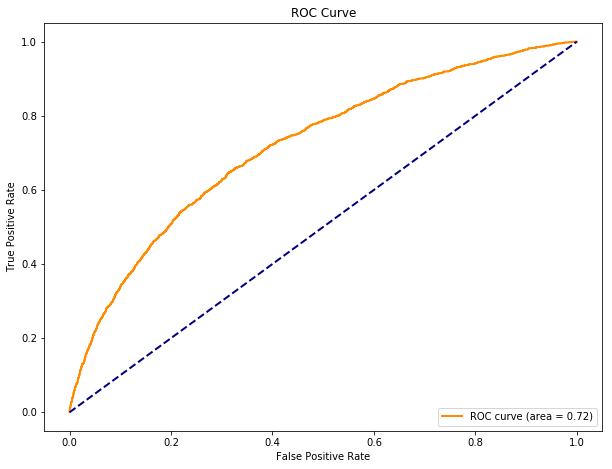

In [110]:
# l1 0.01 balanced f1_test = 0.485282
# l2 0.01 balanced f1_test = 0.483491

# l1 0.001 orig f1 = 0.511950840163
# l2 0.0001 orig f1 = 0.501479445524

#l2 1 
#l1 0.1

clf = LogisticRegression(penalty='l2', C=1, class_weight='balanced', fit_intercept=True, random_state=r, n_jobs=-1)
fit_and_score(clf, 'ale')
#fit_and_score(clf, 'ale_pca')
fit_and_score(clf, 'baseline')

from sklearn.metrics import roc_curve, auc

X, y, X_test, y_test = retrieve_dataset('ale')
clf.fit(X, y)
print(clf.coef_)

y_score = clf.decision_function(X_test)
# Compute ROC curve and ROC area for each class
fpr, tpr, t = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# t_sigm = 1 / (1 + np.exp(-t))

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [346]:
cv=StratifiedKFold(n_splits=5, random_state=r, shuffle=True)

#parameters = {'C': [1e-10, 1e-7, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e2, 1e3, 1e4]}
#clf = LogisticRegression(penalty='l2', class_weight='balanced', fit_intercept=True, random_state=r, n_jobs=1)

#parameters = {'max_depth':[1,2,3,4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]}
#clf = DecisionTreeClassifier(random_state=r, class_weight='balanced')

#parameters = {'C': [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e2, 1e3, 1e4]}
#clf = svm.SVC(random_state=random_state, class_weight='balanced')

#parameters = {'n_estimators': np.arange(1,100)}
#clf = RandomForestClassifier(random_state=random_state, class_weight='balanced')

#parameters = {'priors': [[0.1, 0.9], [0.2, 0.8], [0.5, 0.5], [0.8, 0.2], [0.9, 0.1]]}
#clf = GaussianNB()

parameters = {'hidden_layer_sizes': np.arange(2,30)}
clf = MLPClassifier(activation='logistic', random_state=r)

#parameters = {'n_neighbors': [1, 5, 10, 15, 20, 25, 30]}
#clf = KNeighborsClassifier(n_jobs=-1)

dataset_name = 'ale_pca'
scoring_name = 'f1'
n_jobs = -1
if scoring_name == ms:
    n_jobs = 1
gscv = GridSearchCV(estimator=clf, param_grid=parameters, n_jobs=n_jobs, cv=cv, scoring=scoring_name)
X, y, X_test, y_test = retrieve_dataset(dataset_name)
gscv.fit(X, y)
print('GridSearchCV done on dataset ' + dataset_name)
print(gscv.best_params_)
print(scoring_name + ' = ' + str(gscv.best_score_))

GridSearchCV done on dataset ale_pca
{'hidden_layer_sizes': 27}
f1 = 0.219334988054


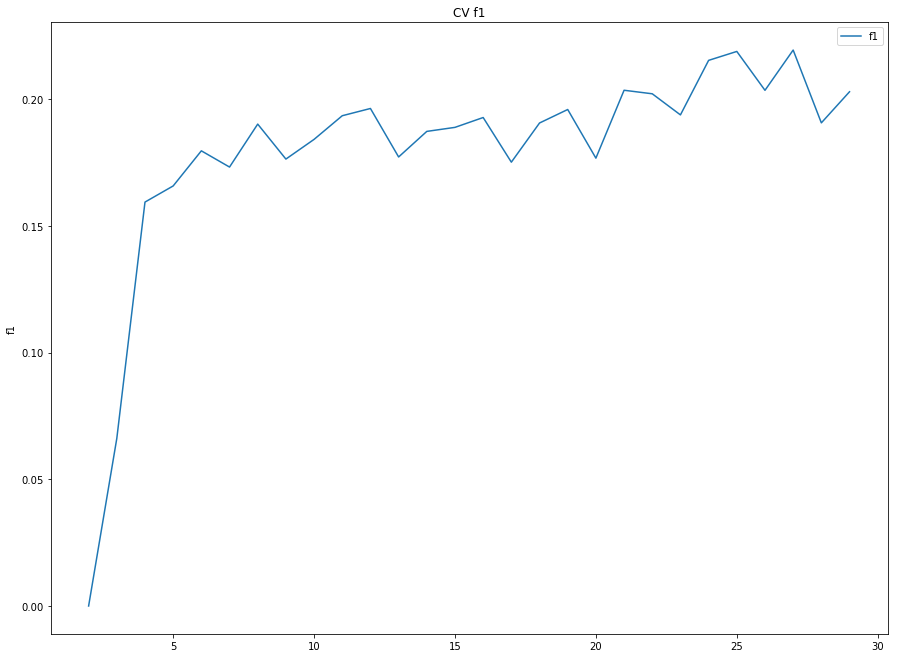

In [347]:
plt.figure(1)
if scoring_name == ms:
    scoring_name = 'Cost'
#plt.plot([prior[0] for prior in parameters['priors']], gscv.cv_results_['mean_test_score'], label=scoring_name)
#plt.plot(parameters['n_estimators'], gscv.cv_results_['mean_test_score'], label=scoring_name)
#plt.plot(parameters['C'], gscv.cv_results_['mean_test_score'], label=scoring_name)
#plt.semilogx(parameters['C'], gscv.cv_results_['mean_test_score'], label=scoring_name, marker='o', color='b')
#plt.plot(parameters['max_depth'], gscv.cv_results_['mean_test_score'], label=scoring_name)
plt.plot(parameters['hidden_layer_sizes'], gscv.cv_results_['mean_test_score'], label=scoring_name)
#plt.plot(parameters['n_neighbors'], gscv.cv_results_['mean_test_score'], label=scoring_name)
# plt.xlabel('C')
plt.ylabel(scoring_name)
plt.title('CV ' + scoring_name)
plt.legend(loc='best')
plt.show()

In [ ]:
target = pd.read_csv("./common/target.csv")
target = target.drop([target_col_name], 1)
target_nan = target[pd.isnull(target).any(axis=1)]

In [82]:
def modelfit(alg, dtrain, predictors, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, show_progress=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Disbursed'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print( "Accuracy : %.4g" % metrics.accuracy_score(dtrain['Disbursed'].values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Disbursed'], dtrain_predprob))
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [114]:
X, y, X_test, y_test = retrieve_dataset('ale')
# model = xgb.XGBClassifier(seed=r, scale_pos_weight=4, nthread=4)
# #     scale_pos_weight=4,
# #  learning_rate =0.1,
# #  n_estimators=1000,
# #  max_depth=5,
# #  min_child_weight=1,
# #  gamma=0,
# #  subsample=0.8,
# #  colsample_bytree=0.8,
# #  objective= 'binary:logistic',
# #  nthread=4,
# #  seed=27)
# xgb1 = xgb
# train = X
# predictors = y
# modelfit(xgb1, train, predictors)
#model.fit(X, y)
#fit_and_score(model, 'ale')
#k = list(map(lambda x: x * 7.8 + 2.2, y))
#k = y
model = xgb.XGBClassifier(seed=r, scale_pos_weight=4, nthread=4)
model.fit(X, y)
f1_train = f1_score(y, model.predict(X))  
f1_test = f1_score(y_test, model.predict(X_test))
print(f1_train)
print(f1_test)
cm_train = confusion_matrix(y, model.predict(X))
cm_test = confusion_matrix(y_test, model.predict(X_test))
print('cm_train = \n{}\ncm_test = \n{}'.format(cm_train, cm_test))
#help(model)

0.554495228528
0.528533442422
cm_train = 
[[10817  3213]
 [ 1222  2760]]
cm_test = 
[[5275 1635]
 [ 670 1292]]


# Learning Ensemble - Level 2 algorithms

In [93]:
X, y, X_test, y_test = retrieve_dataset('meta')

KeyError: 'meta'